In [1]:
# Installing lower version of tensorflow, as the leatest doesn't work with 
# mixed precision policy

!pip install tensorflow==2.11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 32.6 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing i

In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-33736d5f-9f79-ef1c-c543-6c7c91963748)


In [2]:
# Importing libraries needed for this project

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import EfficientNetB0

from matplotlib import image as mpimg
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import os
import random
import itertools
import datetime
import zipfile

In [5]:
# Creating functions that will be used in the project

def load_and_prep_image(file_path,
                        img_shape=224,
                        scale=True):
  
  """
  Loads an image from a given file path and turns it into a tensor 
  of a predefined shape (img_shape,img_shape,3).

  Args:
  
    file_path (str): string path to an image
    img_shape (int): expected size of returned tensor (default = 224)
    scale (bool): information whether to scale pixel values (default = True)
  
  Returns:

    Tensor representation of a given image.
  """

  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img


def make_conf_matrix(y_true,
                     y_pred,
                     classes=None,
                     figsize=(10, 10),
                     text_size=15,
                     norm=False,
                     savefig=False): 
                        

  """
  
  Prepares a confusion matrix that compares predictions to ground truth labels.

  Args:

    y_true: array with ground truth labels
    y_pred: array with predictions
    classes: array of class names 
    figsize: expected size of figure (default = (10, 10)).
    text_size: expected size of text on a figure (default=15).
    norm: information whthere to normalize values or not (default=False).
    savefig: information whether to save confusion matrix to a file (default=False).
  
  Returns:

    Confusion matrix plot that compares predictions to ground truth labels.

  """  
  
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes), 
         xticklabels=labels,
         yticklabels=labels)
  
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  if savefig:
    fig.savefig("confusion_matrix.png")


def pred_and_plot(model,
                  file_path, 
                  class_names):
  """
  Loads an image from a give path and makes a prediction on it with
  provided model, plotting the image with its prediction at the end.

  Args:
    
    model: pretrained model to perform predictions with
    file_path: path to an image that we whant to make prediction on
    class_names: names of available classes that we're predicting
  
  Returns:

    Plots provided image along with it's predicted lable in the title
  """


  img = load_and_prep_image(file_path)
  pred = model.predict(tf.expand_dims(img, axis=0))

  if len(pred[0]) > 1: 
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")


def create_tensorboard_callback(dir_name,
                                experiment_name):
  
  """
  Creates a TensorBoard callback to store training log files.

  Args:
  
    dir_name: target location to keep TensorBoard log files
    experiment_name: name of experiment to distinguish log files between eachother

  Returns:
  
    TensorBoard callback obejct to be used a one of parameters during
    model training process.
  """

  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tb_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  
  return tb_callback



def plot_training_curves(history):

  """
  Plots separate training curves for training and validation set.

  Args:
  
    history: TensorFlow model History object
  
  Returns:
  
    Plot of separate training curves for training and validation set.
  """ 
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize = (24,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();




def compare_histories(org_history,
                     new_history, 
                     init_epochs=5):
  
    """
    Compares two TensorFlow model History objects.
    
    Args:

      org_history: History object from original model
      new_history: History object from fine tuned model
      init_epochs: Number of epochs in initial training stage


    Returns:

    Plots showing training curves of training and valuation set,
    before and after tunning phase

    """
    
    acc = org_history.history["accuracy"]
    loss = org_history.history["loss"]

    val_acc = org_history.history["val_accuracy"]
    val_loss = org_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([init_epochs-1, 
              init_epochs-1],
              plt.ylim(),
             label='Start Fine Tuning')
    
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([init_epochs-1,
              init_epochs-1],
              plt.ylim(),
             label='Start Fine Tuning')
    
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


def unzip_data(file_path):
  
  """
  Extracts file from a file_path into current working directory.

  Args:
    
    file_path (str): a file path to a file that needs to be extracted.
  
  Returns:

    Extracts file from a file_path into current working directory.

  """
  
  zip_ref = zipfile.ZipFile(file_path, "r")
  zip_ref.extractall()
  zip_ref.close()



def walk_through_dir(dir_path):

  """
  Walks through dir_path returning its contents.

  Args:
  
    dir_path (str): target directory
  
  Returns:

    Prints out the number and names of subdirectories, along with
    number of files in each subdirectory
  """
  
  for dir_path, dir_names, file_names in os.walk(dir_path):
    print(f"There are {len(dir_names)} directories and {len(file_names)} images in '{dir_path}'.")



from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):

  """
  Calculates model accuracy, precision, recall and f1 score 
  of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  
  
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}

  return model_results


def prepare_img(img,
                lbl,
                img_shape = 224):
  
  """
  Converts image dtype from 'uint8' -> 'float32' and reshapes it
  to [img_shape,img_shape,color_channels]

  Args:
    img: Tensor object representing an image
    lbl: Numerical representation of image label
    img_shape: Expected size of an image after preparation

  Returns:

    A tuple consisting of preprocessed image and corresponding lablel
  """
  
  img = tf.image.resize(images = img,
                        size = [img_shape,img_shape])
  
  img = tf.cast(img,
                dtype = tf.float32)
  
  return img,lbl

In [6]:
# Import food101 dataset from TensorFlow datasets

(train_set, test_set), ds_info = tfds.load(name = 'food101',
                                           split = ['train','validation'],
                                           shuffle_files = True,
                                           as_supervised = True,
                                           with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete7SUHPC/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete7SUHPC/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
# Explore downloaded dataset

ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
class_names = ds_info.features['label'].names

class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
single_sample = train_set.take(1)

In [10]:
single_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
for img, lbl in single_sample:
  print(f'''
  Image shape: {img.shape}
  Image dtype: {img.dtype}
  Image class indx: {lbl}
  Image class name: {class_names[lbl.numpy()]}
  ''')


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image class indx: 49
  Image class name: grilled_cheese_sandwich
  


In [12]:
tf.reduce_min(img).numpy(),tf.reduce_max(img).numpy()

(0, 255)

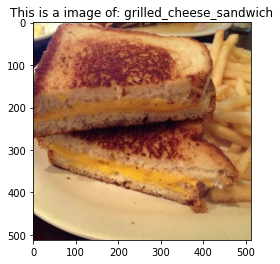

In [13]:
plt.imshow(img)
plt.title(f'This is a image of: {class_names[lbl.numpy()]}')
plt.show();

In [14]:
# Preprocess sample image to check if prepared function works properly

preprocessed_img = prepare_img(img,lbl)

In [15]:
preprocessed_img[0].shape, preprocessed_img[0].dtype

(TensorShape([224, 224, 3]), tf.float32)

In [16]:
# Apply preprocessing function on all available samples

train_set = train_set.map(map_func = prepare_img,
                          num_parallel_calls = tf.data.AUTOTUNE)

# Shuffle training data, turn it into batches and 

train_set = train_set.shuffle(buffer_size = 1000) \
                     .batch(batch_size = 32) \
                     .prefetch(buffer_size = tf.data.AUTOTUNE) 

# Apply preprocessing function on all available samples

test_set = test_set.map(map_func = prepare_img,
                        num_parallel_calls = tf.data.AUTOTUNE)

# Shuffle training data, turn it into batches and 

test_set = test_set.shuffle(buffer_size = 1000) \
                   .batch(batch_size = 32) \
                   .prefetch(buffer_size = tf.data.AUTOTUNE) 

In [17]:
train_set,test_set

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [18]:
# Create callbacks usefull in the process of training our model

tb_callback = create_tensorboard_callback(dir_name = 'tensorboard_callbacks',
                                          experiment_name = 'model_0')

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = 'checkpoint_callbacks/cp.ckpt',
                                                 monitor = 'val_acc',
                                                 save_best_only = True,
                                                 save_weights_only = True,
                                                 save_freq = 'epoch')



In [19]:
# Applying mixed precision policy into training process to increase its speed

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Check if policy applied

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)



Compute dtype: float16
Variable dtype: float32


In [20]:
# Building & compiling base future extraction model 

base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = Input(shape = (224,224,3),
               name = 'Input layer')

x = base_model(inputs,
               training = False)

x = GlobalAveragePooling2D()(x)
x = Dense(len(class_names))(x)
outputs = Activation(activation = 'softmax', dtype = 'float32')(x)
model_0 = keras.Model(inputs,outputs)


model_0.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics = ['accuracy']
)



16705208/16705208 [==============================] - 2s 0us/step


In [21]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [22]:
for i,l in enumerate(model_0.layers):
  print(i,' - ',l.name,' - ',l.trainable,' - ',l.dtype,' - ',l.dtype_policy)

0  -  Input layer  -  True  -  float32  -  <Policy "float32">
1  -  efficientnetb0  -  False  -  float32  -  <Policy "mixed_float16">
2  -  global_average_pooling2d  -  True  -  float32  -  <Policy "mixed_float16">
3  -  dense  -  True  -  float32  -  <Policy "mixed_float16">
4  -  activation  -  True  -  float32  -  <Policy "float32">


In [23]:
history_0 = model_0.fit(train_set,
                        epochs = 3,
                        verbose = 1,
                        validation_data = test_set,
                        validation_steps = int(0.15*len(test_set)),
                        steps_per_epoch = len(train_set),
                        callbacks = [tb_callback,
                                    cp_callback])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7188 - accuracy: 0.5819

2368/2368 [==============================] - 208s 81ms/step - loss: 1.7188 - accuracy: 0.5819 - val_loss: 1.1272 - val_accuracy: 0.7007
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1997 - accuracy: 0.6882

2368/2368 [==============================] - 188s 79ms/step - loss: 1.1997 - accuracy: 0.6882 - val_loss: 1.0548 - val_accuracy: 0.7103
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0537 - accuracy: 0.7232

2368/2368 [==============================] - 184s 77ms/step - loss: 1.0537 - accuracy: 0.7232 - val_loss: 1.0186 - val_accuracy: 0.7182


In [24]:
model_0.evaluate(test_set)

790/790 [==============================] - 65s 77ms/step - loss: 1.0056 - accuracy: 0.7253


[1.0056074857711792, 0.7253069281578064]